In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision
import numpy as np
import torch

import mnist_shootout
import pt_linreg
import pt_logreg
import ksvm_wrap
import pt_deep
import fcann2
import data

sns.set_theme()
sns.set_style("whitegrid")
np.random.seed(100)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 2. Višeslojna klasifikacija u Pythonu (20% bodova)
---
Implementiran je dvoslojni model koji klasicifira 2D podatke. Kao aktivacijska funkcija skrivenog sloja je korištena zglobnica, odnosno ReLu dok se finalni logiti propuštaju kroz softmax kako bismo dobili probibalističku interpretaciju.

Epoch 0/10000, loss: 41.96733388956766
Epoch 1000/10000, loss: 33.74700572899259
Epoch 2000/10000, loss: 26.986764444303173
Epoch 3000/10000, loss: 22.231446246141743
Epoch 4000/10000, loss: 19.723251496973887
Epoch 5000/10000, loss: 18.138364037223337
Epoch 6000/10000, loss: 17.131125178525718
Epoch 7000/10000, loss: 16.700349956670046
Epoch 8000/10000, loss: 16.344408091073444
Epoch 9000/10000, loss: 16.049806969920652


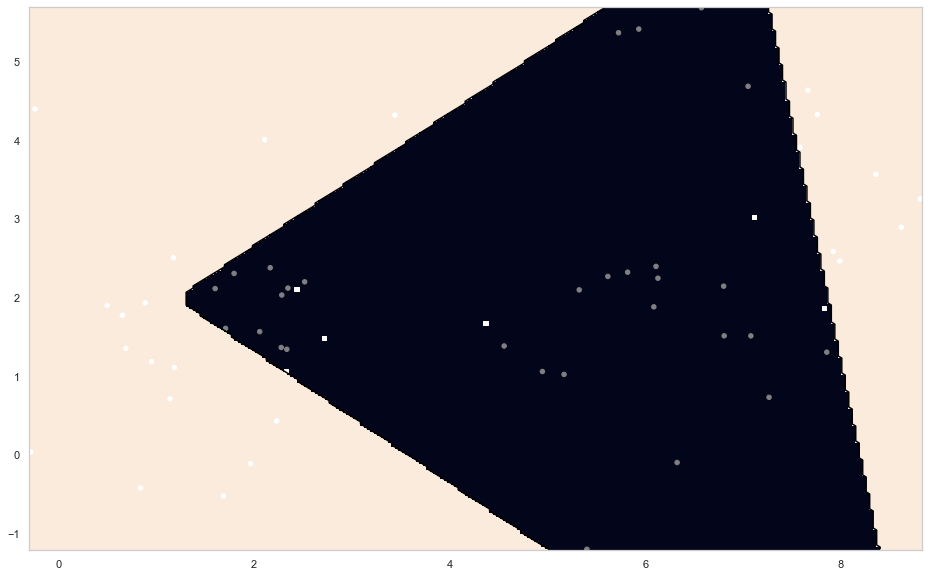

In [7]:
# instanciraj podatke X i labele Yoh_
np.random.seed(100)
X, Y_ = data.sample_gmm_2d(6, 2, 10)
Yoh = data.class_to_onehot(Y_)

w1, b1, w2, b2 = fcann2.fcann2_train(X, Y_, 5, 10000, 0.05, 1e-3, 1000)

Y = fcann2.fcann2_classify(X, w1, b1, w2, b2)

figure = plt.figure(figsize=(16, 10))
fun = fcann2.decfun(X, w1, b1, w2, b2)
bbox = (np.min(X, axis=0), np.max(X, axis=0))

data.graph_surface(fun, bbox, offset=0.5)
data.graph_data(X, Y_, Y)
plt.show()

## 3. Linearna regresija u PyTorchu (10% bodova)
---
Kako bih demonstrirala rad ovog zadatka, implementirala sam dodatnu funkciju u modulu data.py koja generira regresijski pravac s nadodanim šumom. Funkcija se zove sample lr data i prima 3 argumenta: veličinu uzorka, koeficijent nagiba pravca i vrijednost varijance/šuma.

Dani primjerak koda u Pytorchu sam izmijenila na način da sam uvela funkciju MSE koja usrednjeni kvadratni gubitak. Na taj način je sam kod za lineranu regresiju neovisan o veličini ulaznih podataka (X i Y).

Nadalje, dodala sam i ručno računanje gradijenata za koeficijente a i b:
$\nabla_a = 2(Y_{gt} - Y_{pred}) \times X$ i $\nabla_b = 2(Y_{gt} - Y_{pred})$

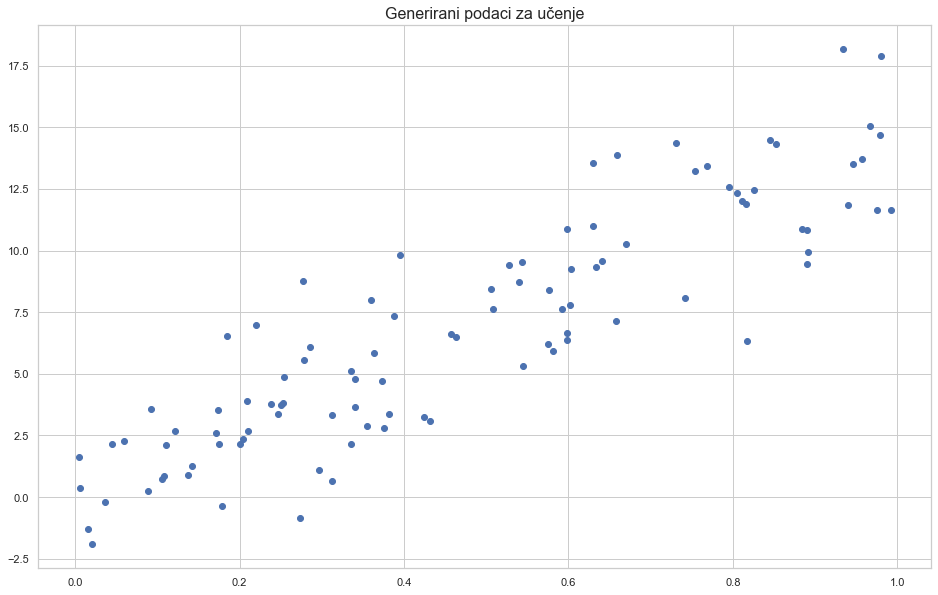

In [3]:
X, Y_ = data.sample_lr_data(100, 15, 2)
fig = plt.figure(figsize=(16, 10))
plt.scatter(X, Y_)
plt.title("Generirani podaci za učenje", fontsize=16)
plt.show()

In [4]:
X_t, Y_t = torch.Tensor(X), torch.Tensor(Y_)
a, b = pt_linreg.linear_regression(X_t, Y_t, 1000, 0.1)
Y = a*X_t + b
Y = Y.detach().numpy()


step: 0, loss:75.37564086914062, a:tensor([1.4559], requires_grad=True), b tensor([0.6392], requires_grad=True)
	step: 0, my a grad: -9.306178092956543, my b grad: -14.769458770751953
	step: 0, pytorch a : -9.306178092956543, pytorch b: -14.769460678100586

step: 100, loss:5.270206451416016, a:tensor([11.7240], requires_grad=True), b tensor([1.3502], requires_grad=True)
	step: 100, my a grad: -0.3729567229747772, my b grad: 0.18892410397529602
	step: 100, pytorch a : -0.3729567527770996, pytorch b: 0.18892404437065125

step: 200, loss:4.665562152862549, a:tensor([13.7493], requires_grad=True), b tensor([0.3243], requires_grad=True)
	step: 200, my a grad: -0.09579765051603317, my b grad: 0.04852796718478203
	step: 200, pytorch a : -0.09579767286777496, pytorch b: 0.04852798581123352

step: 300, loss:4.625668525695801, a:tensor([14.2695], requires_grad=True), b tensor([0.0608], requires_grad=True)
	step: 300, my a grad: -0.02460680902004242, my b grad: 0.01246500015258789
	step: 300, py

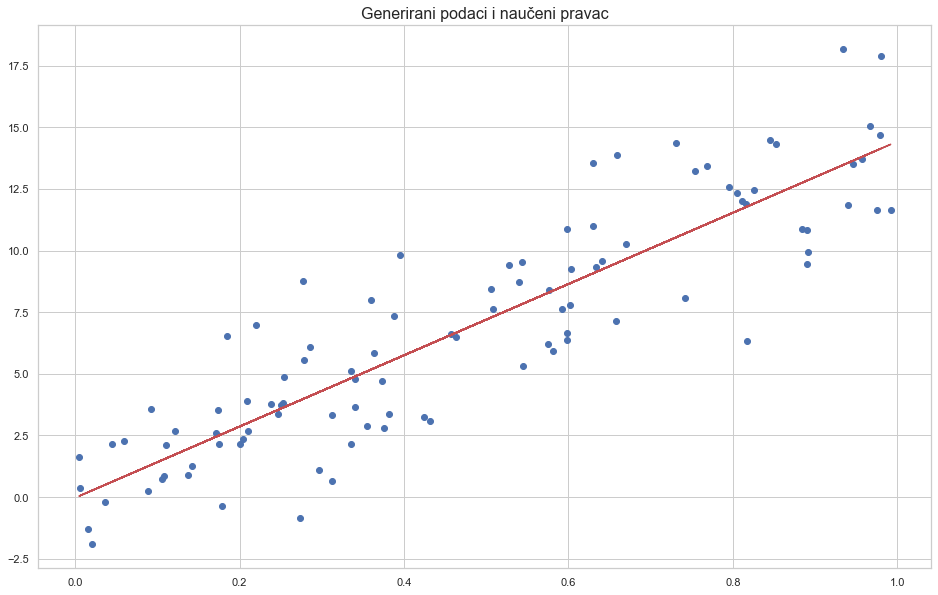

In [5]:
figure = plt.figure(figsize=(16, 10))
plt.scatter(X, Y_)
plt.plot(X, Y, "r-")
plt.title("Generirani podaci i naučeni pravac", fontsize=16)
plt.show()

## 4. Logistička regresija u PyTorchu (20% bodova)
---
Ovaj zadatak je nadogradnja nulte laboratorijske vježbe u kojoj smo ručno implementirali logističku regresiju. Uz korištenje biblioteke PyTorch, implementacija problema logističke regresije se uvelike pojednostavljuje. 

### Provjera ponašanja za slučaj s 2 razreda podataka

Epoch 0/1000, loss = 5.979232311248779
Epoch 250/1000, loss = 0.06940130144357681
Epoch 500/1000, loss = 0.06799410283565521
Epoch 750/1000, loss = 0.06732948869466782
Accuracy: 0.97, precision and recall: [(0.98, 0.9607843137254902), (0.96, 0.9795918367346939)]


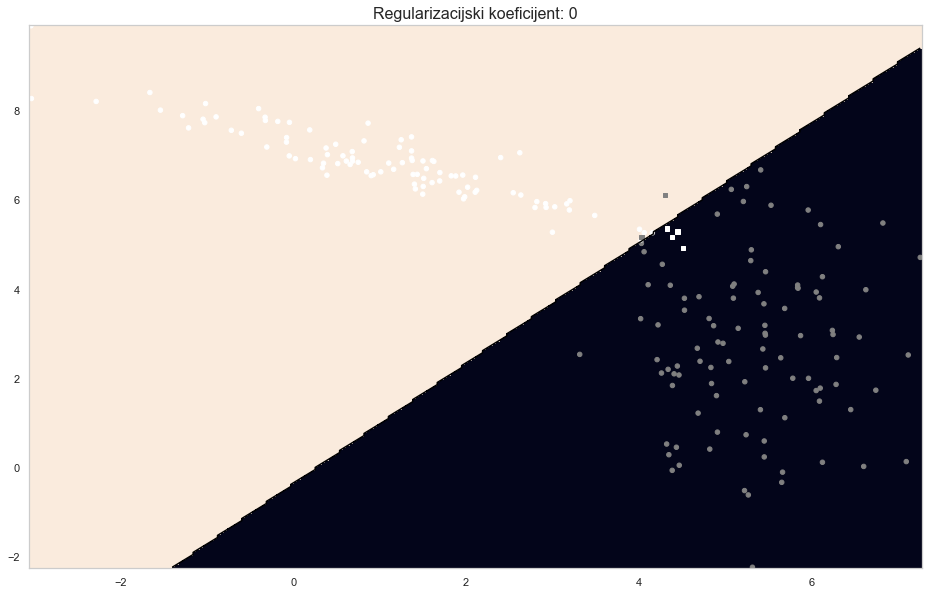

In [6]:
# instanciraj podatke X i labele Yoh_
np.random.seed(100)
x, Y_ = data.sample_gauss_2d(2, 100)
Yoh = data.class_to_onehot(Y_)
X = torch.Tensor(x)
Yoh_ = torch.Tensor(Yoh)

# definiraj model:
ptlr = pt_logreg.PTLogreg(X.shape[1], Yoh_.shape[1])
reg_koef = 0

# nauči parametre (X i Yoh_ moraju biti tipa torch.Tensor):
pt_logreg.train(ptlr, X, Yoh_, 1000, 0.1, reg_koef, 250)

# dohvati vjerojatnosti na skupu za učenje
probs = pt_logreg.eval(ptlr, X)
Y = np.argmax(probs, axis=1)

# ispiši performansu (preciznost i odziv po razredima)
accuracy, precision, recall = data.eval_perf_multi(Y, Y_)
print("Accuracy: {}, precision and recall: {}".format(accuracy, precision))

# iscrtaj rezultate, decizijsku plohu
figure = plt.figure(figsize=(16, 10))
fun = pt_logreg.decfun(ptlr, x)
bbox = (np.min(x, axis=0), np.max(x, axis=0))

data.graph_surface(fun, bbox, offset=0.5)
data.graph_data(x, Y_, Y)
plt.title("Regularizacijski koeficijent: {}".format(reg_koef), fontsize=16)
plt.show()

### Provjera ponašanja za slučaj s 3 razreda

Epoch 0/1000, loss = 7.122474670410156
Epoch 250/1000, loss = 0.3053687512874603
Epoch 500/1000, loss = 0.241652250289917
Epoch 750/1000, loss = 0.20394273102283478
Accuracy: 0.9566666666666667, precision and recall: [(0.9, 0.967741935483871), (0.97, 0.9797979797979798), (1.0, 0.9259259259259259)]


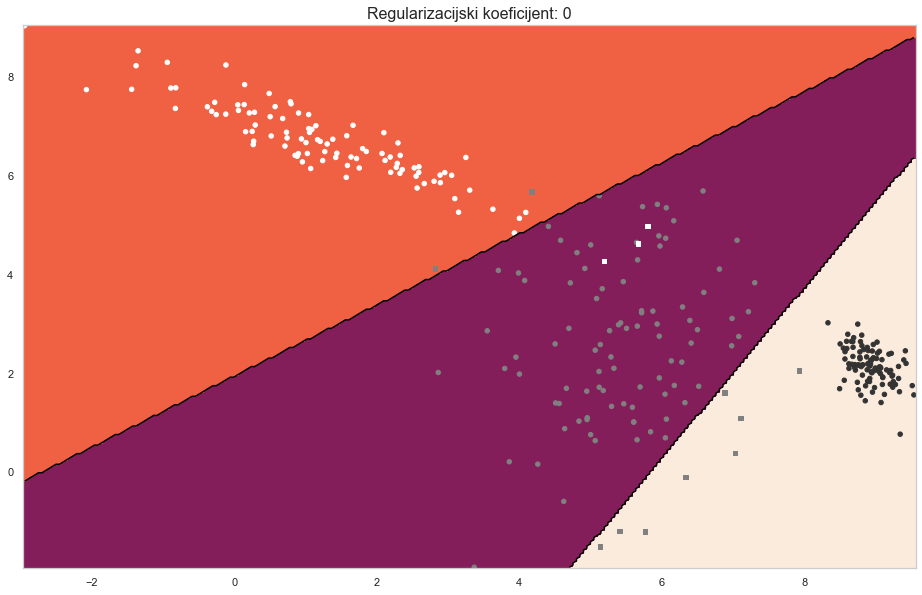

In [7]:
# instanciraj podatke X i labele Yoh_
np.random.seed(100)
x, Y_ = data.sample_gauss_2d(3, 100)
Yoh = data.class_to_onehot(Y_)
X = torch.Tensor(x)
Yoh_ = torch.Tensor(Yoh)

# definiraj model:
ptlr = pt_logreg.PTLogreg(X.shape[1], Yoh_.shape[1])
reg_koef = 0

# nauči parametre (X i Yoh_ moraju biti tipa torch.Tensor):
pt_logreg.train(ptlr, X, Yoh_, 1000, 0.1, reg_koef, 250)

# dohvati vjerojatnosti na skupu za učenje
probs = pt_logreg.eval(ptlr, X)
Y = np.argmax(probs, axis=1)

# ispiši performansu (preciznost i odziv po razredima)
accuracy, precision, recall = data.eval_perf_multi(Y, Y_)
print("Accuracy: {}, precision and recall: {}".format(accuracy, precision))

# iscrtaj rezultate, decizijsku plohu
figure = plt.figure(figsize=(16, 10))
fun = pt_logreg.decfun(ptlr, x)
bbox = (np.min(x, axis=0), np.max(x, axis=0))

data.graph_surface(fun, bbox, offset=0.5)
data.graph_data(x, Y_, Y)
plt.title("Regularizacijski koeficijent: {}".format(reg_koef), fontsize=16)
plt.show()

### Ispitivanje utjecaja regularizacijskog koeficijenta $\lambda$

Vidimo da se povecanjem lambde dobivaju losiji rezultati te da se tocka presjeka tri decizijske granice pomice prema sredini.

Epoch 0/1000, loss = 8.540128707885742
Epoch 250/1000, loss = 0.457854688167572
Epoch 500/1000, loss = 0.4059438705444336
Epoch 750/1000, loss = 0.37884604930877686
Accuracy: 0.97, precision and recall: [(0.95, 0.9595959595959596), (0.96, 0.9795918367346939), (1.0, 0.970873786407767)]


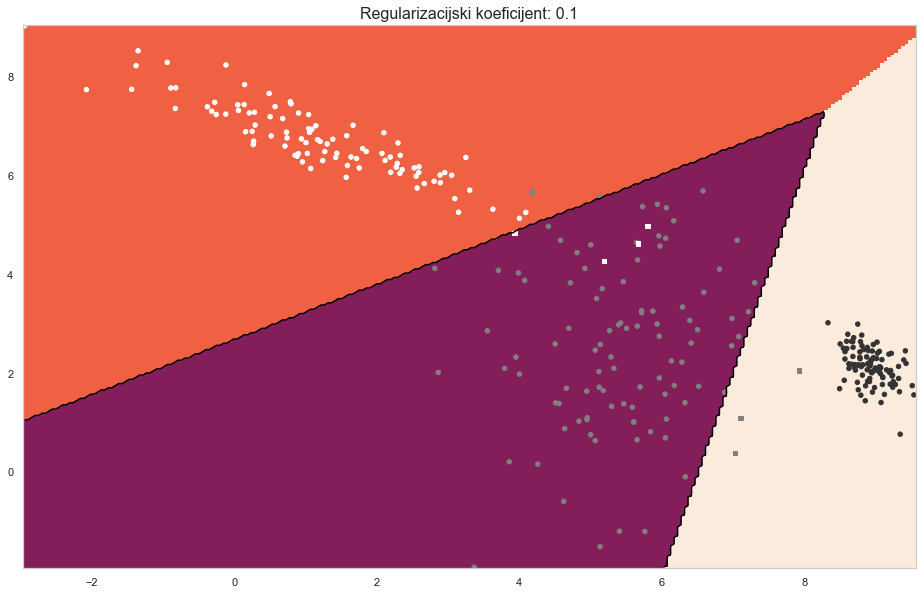

In [8]:
# definiraj model:
ptlr = pt_logreg.PTLogreg(X.shape[1], Yoh_.shape[1])
reg_koef = 1e-1

# nauči parametre (X i Yoh_ moraju biti tipa torch.Tensor):
pt_logreg.train(ptlr, X, Yoh_, 1000, 0.1, reg_koef, 250)

# dohvati vjerojatnosti na skupu za učenje
probs = pt_logreg.eval(ptlr, X)
Y = np.argmax(probs, axis=1)

# ispiši performansu (preciznost i odziv po razredima)
accuracy, precision, recall = data.eval_perf_multi(Y, Y_)
print("Accuracy: {}, precision and recall: {}".format(accuracy, precision))

# iscrtaj rezultate, decizijsku plohu
figure = plt.figure(figsize=(16, 10))
fun = pt_logreg.decfun(ptlr, x)
bbox = (np.min(x, axis=0), np.max(x, axis=0))

data.graph_surface(fun, bbox, offset=0.5)
data.graph_data(x, Y_, Y)
plt.title("Regularizacijski koeficijent: {}".format(reg_koef), fontsize=16)
plt.show()

Epoch 0/1000, loss = 10.655632019042969
Epoch 250/1000, loss = 0.7559823393821716
Epoch 500/1000, loss = 0.7378597259521484
Epoch 750/1000, loss = 0.7323909997940063
Accuracy: 0.9433333333333334, precision and recall: [(0.86, 0.9662921348314607), (0.97, 0.9603960396039604), (1.0, 0.9090909090909091)]


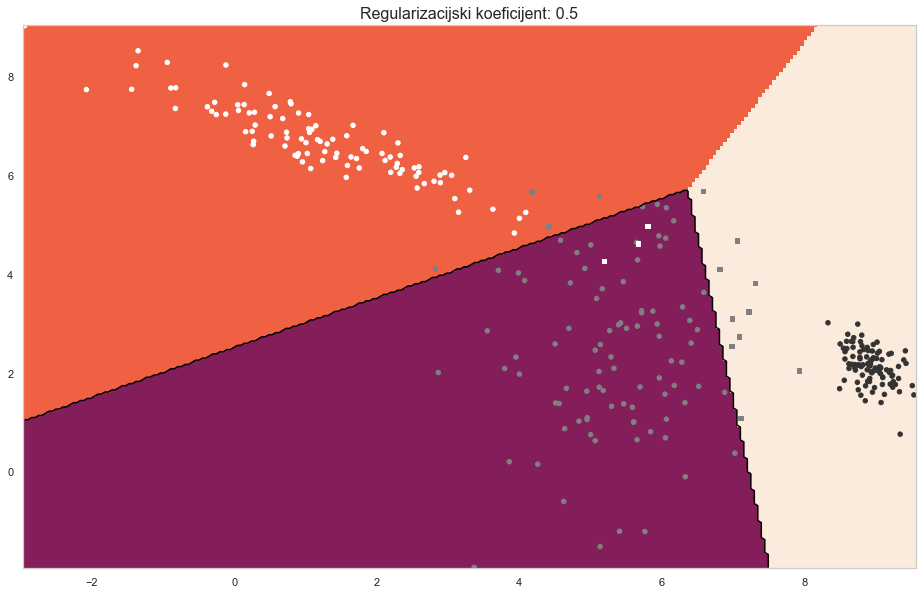

In [9]:
# definiraj model:
ptlr = pt_logreg.PTLogreg(X.shape[1], Yoh_.shape[1])
reg_koef = 0.5

# nauči parametre (X i Yoh_ moraju biti tipa torch.Tensor):
pt_logreg.train(ptlr, X, Yoh_, 1000, 0.1, reg_koef, 250)

# dohvati vjerojatnosti na skupu za učenje
probs = pt_logreg.eval(ptlr, X)
Y = np.argmax(probs, axis=1)

# ispiši performansu (preciznost i odziv po razredima)
accuracy, precision, recall = data.eval_perf_multi(Y, Y_)
print("Accuracy: {}, precision and recall: {}".format(accuracy, precision))

# iscrtaj rezultate, decizijsku plohu
figure = plt.figure(figsize=(16, 10))
fun = pt_logreg.decfun(ptlr, x)
bbox = (np.min(x, axis=0), np.max(x, axis=0))

data.graph_surface(fun, bbox, offset=0.5)
data.graph_data(x, Y_, Y)
plt.title("Regularizacijski koeficijent: {}".format(reg_koef), fontsize=16)
plt.show()

Epoch 0/1000, loss = 8.749856948852539
Epoch 250/1000, loss = 0.9735249876976013
Epoch 500/1000, loss = 0.9584517478942871
Epoch 750/1000, loss = 0.9550114274024963
Accuracy: 0.7933333333333333, precision and recall: [(0.41, 1.0), (0.97, 0.8981481481481481), (1.0, 0.6622516556291391)]


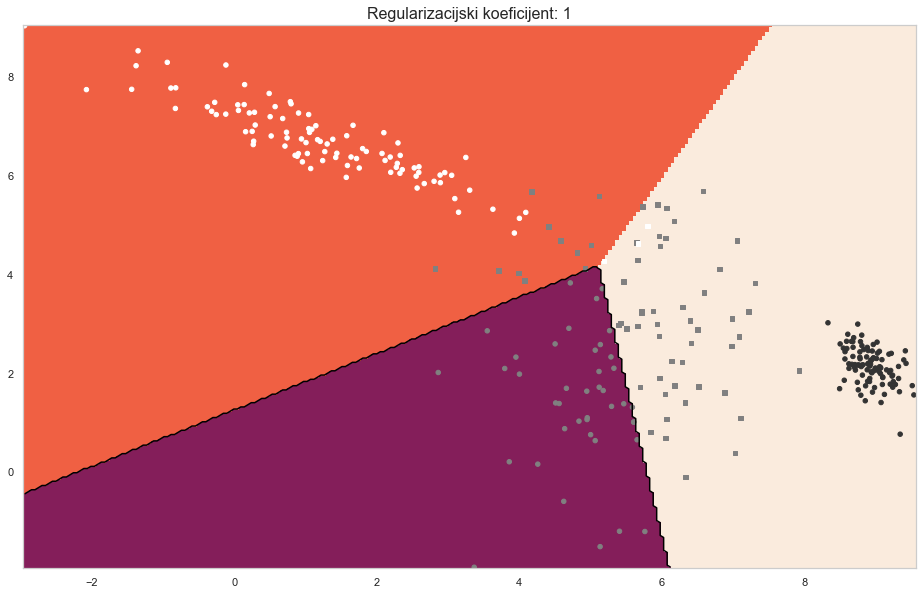

In [10]:
# definiraj model:
ptlr = pt_logreg.PTLogreg(X.shape[1], Yoh_.shape[1])
reg_koef = 1

# nauči parametre (X i Yoh_ moraju biti tipa torch.Tensor):
pt_logreg.train(ptlr, X, Yoh_, 1000, 0.1, reg_koef, 250)

# dohvati vjerojatnosti na skupu za učenje
probs = pt_logreg.eval(ptlr, X)
Y = np.argmax(probs, axis=1)

# ispiši performansu (preciznost i odziv po razredima)
accuracy, precision, recall = data.eval_perf_multi(Y, Y_)
print("Accuracy: {}, precision and recall: {}".format(accuracy, precision))

# iscrtaj rezultate, decizijsku plohu
figure = plt.figure(figsize=(16, 10))
fun = pt_logreg.decfun(ptlr, x)
bbox = (np.min(x, axis=0), np.max(x, axis=0))

data.graph_surface(fun, bbox, offset=0.5)
data.graph_data(x, Y_, Y)
plt.title("Regularizacijski koeficijent: {}".format(reg_koef), fontsize=16)
plt.show()

### Slučaj nepovoljnih hiperparametara i lošeg ponašanja modela

Epoch 0/1000, loss = 9.19278621673584
Epoch 250/1000, loss = 4.737290382385254
Epoch 500/1000, loss = 1.2789270877838135
Epoch 750/1000, loss = 0.6045070290565491
Accuracy: 0.7066666666666667, precision and recall: [(0.15, 0.8333333333333334), (0.97, 0.9326923076923077), (1.0, 0.5617977528089888)]


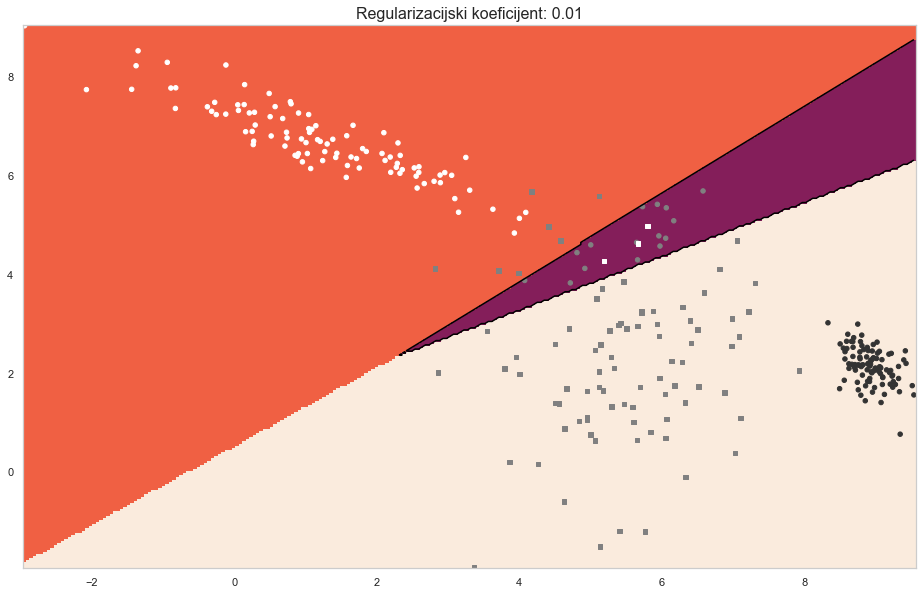

In [11]:
# definiraj model:
ptlr = pt_logreg.PTLogreg(X.shape[1], Yoh_.shape[1])
reg_koef = 1e-2

# nauči parametre (X i Yoh_ moraju biti tipa torch.Tensor):
pt_logreg.train(ptlr, X, Yoh_, 1000, 0.001, reg_koef, 250)

# dohvati vjerojatnosti na skupu za učenje
probs = pt_logreg.eval(ptlr, X)
Y = np.argmax(probs, axis=1)

# ispiši performansu (preciznost i odziv po razredima)
accuracy, precision, recall = data.eval_perf_multi(Y, Y_)
print("Accuracy: {}, precision and recall: {}".format(accuracy, precision))

# iscrtaj rezultate, decizijsku plohu
figure = plt.figure(figsize=(16, 10))
fun = pt_logreg.decfun(ptlr, x)
bbox = (np.min(x, axis=0), np.max(x, axis=0))

data.graph_surface(fun, bbox, offset=0.5)
data.graph_data(x, Y_, Y)
plt.title("Regularizacijski koeficijent: {}".format(reg_koef), fontsize=16)
plt.show()

## 5. Konfigurabilni duboki modeli u PyTorchu (20% bodova)
---
U ovom zadatku implementirali smo model koji može biti proizvoljne dubine. Model je implementiram pomoću biblioteke PyTorch i po uzoru na dani kod iz prethodnog zadatka.

Rezultati su prikazani u nastavku. Za svaki eksperiment su paralelno prikazani rezultati uz korištenje aktivacije zglobnice i softmaxa.

In [12]:
# iscrtaj rezultate, decizijsku plohu
def show_relu_sigmoid(x, Y_, arh, akt1, akt2, model1, Y1, model2, Y2):  
    figure = plt.figure(figsize=(20, 8))

    plt.subplot(1, 2, 1)
    fun = pt_deep.decfun(model1, x)
    bbox = (np.min(x, axis=0), np.max(x, axis=0))
    data.graph_surface(fun, bbox, offset=0.5)
    data.graph_data(x, Y_, Y1)
    plt.title("Model s arhiekturom {} i funkcijom {}".format(arh, akt1))

    plt.subplot(1, 2, 2)
    fun = pt_deep.decfun(model2, x)
    bbox = (np.min(x, axis=0), np.max(x, axis=0))
    data.graph_surface(fun, bbox, offset=0.5)
    data.graph_data(x, Y_, Y2)
    plt.title("Model s arhiekturom {} i funkcijom {}".format(arh, akt2))

    plt.show()
    
def train_deep_relu_sigmoid_models(X, Y_, Yoh_, arh, param_niters=6000, param_delta=0.1, param_lambda=1e-4, print_step=1000):
    #definiraj model:
    ptdeep1 = pt_deep.PTDeep(arh, torch.relu).to(device)
    
    # nauči parametre (X i Yoh_ moraju biti tipa torch.Tensor):
    pt_deep.train(ptdeep1, X, Yoh_, param_niters, param_delta, param_lambda, print_step)

    # dohvati vjerojatnosti na skupu za učenje
    probs = pt_deep.eval(ptdeep1, X)
    Y1 = np.argmax(probs, axis=1)

    # ispiši performansu (preciznost i odziv po razredima)
    accuracy, precision, M = data.eval_perf_multi(Y1, Y_)
    #avg_precision = data.eval_AP(Y_[probs.argsort()])
    avg_precision = 0
    print("Accuracy: {}, precision: {}, average precision: {}\n".format(accuracy, precision,
                                                                      avg_precision))

    # definiraj model:
    ptdeep2 = pt_deep.PTDeep(arh, torch.sigmoid).to(device)

    # nauči parametre (X i Yoh_ moraju biti tipa torch.Tensor):
    pt_deep.train(ptdeep2, X, Yoh_, param_niters, param_delta, param_lambda, print_step)

    # dohvati vjerojatnosti na skupu za učenje
    probs = pt_deep.eval(ptdeep2, X)
    Y2 = np.argmax(probs, axis=1)

    # ispiši performansu (preciznost i odziv po razredima)
    accuracy, precision, M = data.eval_perf_multi(Y2, Y_)
    #avg_precision = data.eval_AP(Y_[probs.argsort()])
    avg_precision = 0
    print("Accuracy: {}, precision: {}, average precision: {}".format(accuracy, precision,
                                                                      avg_precision))
    return ptdeep1, Y1, ptdeep2, Y2

Epoch 0/1000, loss = 4.573047161102295
Epoch 250/1000, loss = 0.7507834434509277
Epoch 500/1000, loss = 0.73636794090271
Epoch 750/1000, loss = 0.7318740487098694
Tensors and its shapes:
 [('weights.0', torch.Size([3])), ('biases.0', torch.Size([3]))]
Total number of parameters:  9
Accuracy: 0.9433333333333334, precision and recall: [(0.86, 0.9662921348314607), (0.97, 0.9603960396039604), (1.0, 0.9090909090909091)]


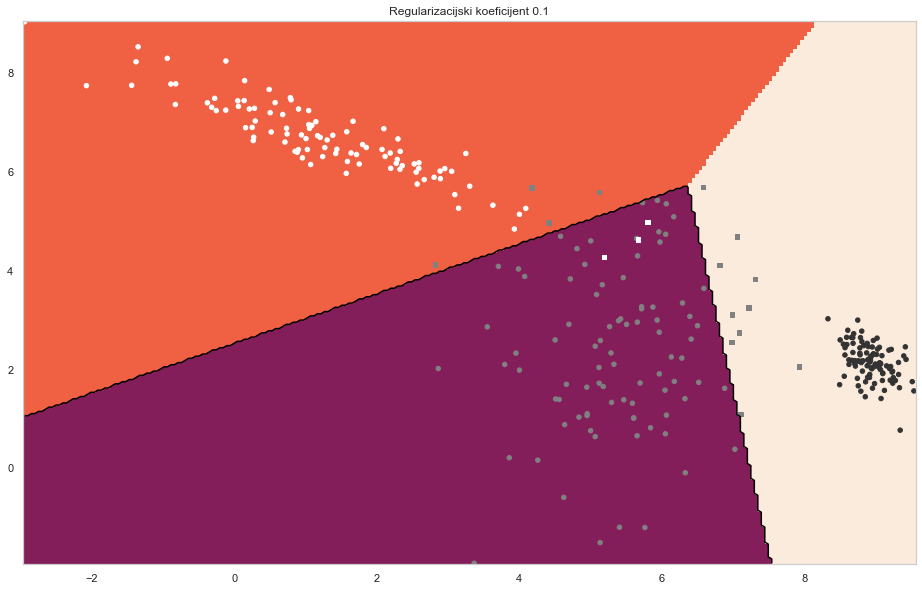

In [13]:
# definiraj model:
ptdeep = pt_deep.PTDeep([2, 3], torch.relu)

# nauči parametre (X i Yoh_ moraju biti tipa torch.Tensor):
pt_deep.train(ptdeep, X, Yoh_, 1000, 0.1, 0.5, 250)

# dohvati vjerojatnosti na skupu za učenje
probs = pt_deep.eval(ptdeep, X)
Y = np.argmax(probs, axis=1)

tensor_shapes, total_params = ptdeep.count_params()
print("Tensors and its shapes:\n", tensor_shapes)
print("Total number of parameters: ", total_params)

# ispiši performansu (preciznost i odziv po razredima)
accuracy, precision, recall = data.eval_perf_multi(Y, Y_)
print("Accuracy: {}, precision and recall: {}".format(accuracy, precision))

# iscrtaj rezultate, decizijsku plohu
figure = plt.figure(figsize=(16, 10))
fun = pt_deep.decfun(ptdeep, x)
bbox = (np.min(x, axis=0), np.max(x, axis=0))

data.graph_surface(fun, bbox, offset=0.5)
data.graph_data(x, Y_, Y)
plt.title("Regularizacijski koeficijent {}".format(1e-1))
plt.show()

In [14]:
# inicijaliziraj generatore slučajnih brojeva
np.random.seed(100)

# instanciraj podatke X i labele Yoh_
x, Y_ = data.sample_gmm_2d(4, 2, 40)
Yoh = data.class_to_onehot(Y_)
X = torch.Tensor(x)
Yoh_ = torch.Tensor(Yoh)

# definiraj model:
arh = [2, 2]
akt1 = "relu"
akt2 = "sigmoid"

ptdeep1, Y1, ptdeep2, Y2 = train_deep_relu_sigmoid_models(X, Y_, Yoh_, arh, param_niters=6000, 
                                                        param_delta=0.1, param_lambda=1e-4, print_step=1000)


Epoch 0/6000, loss = 0.7464394569396973
Epoch 1000/6000, loss = 0.44133272767066956
Epoch 2000/6000, loss = 0.4413303732872009
Epoch 3000/6000, loss = 0.44132983684539795
Epoch 4000/6000, loss = 0.44132936000823975
Epoch 5000/6000, loss = 0.441328763961792
Accuracy: 0.675, precision: [(0.5875, 0.7121212121212122), (0.7625, 0.648936170212766)], average precision: 0

Epoch 0/6000, loss = 1.3524662256240845
Epoch 1000/6000, loss = 0.4413529932498932
Epoch 2000/6000, loss = 0.4413504898548126
Epoch 3000/6000, loss = 0.4413497745990753
Epoch 4000/6000, loss = 0.44134917855262756
Epoch 5000/6000, loss = 0.44134846329689026
Accuracy: 0.675, precision: [(0.5875, 0.7121212121212122), (0.7625, 0.648936170212766)], average precision: 0


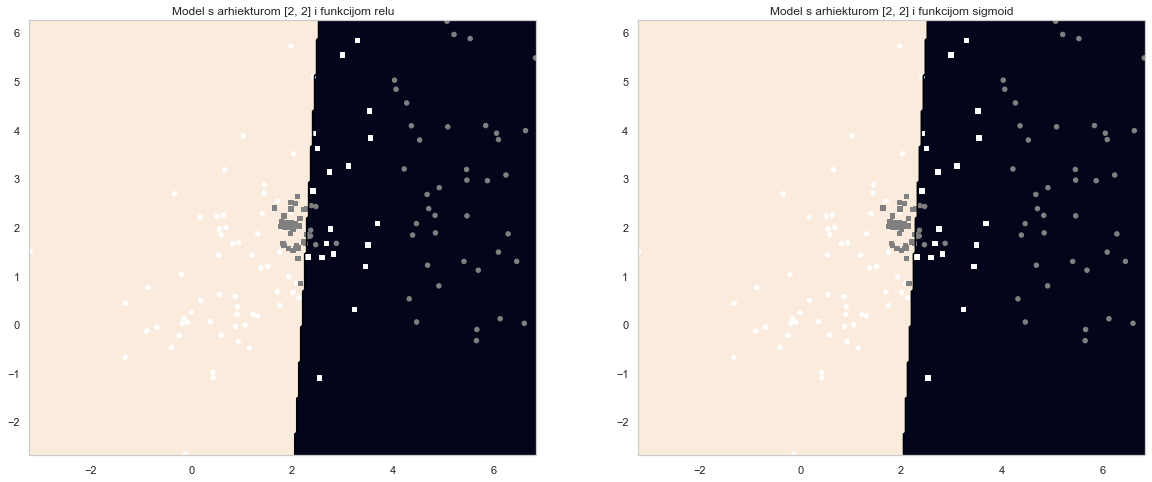

In [15]:
show_relu_sigmoid(x, Y_, arh, akt1, akt2, ptdeep1, Y1, ptdeep2, Y2)

In [16]:
# definiraj model:
arh = [2, 10, 2]

ptdeep1, Y1, ptdeep2, Y2 = train_deep_relu_sigmoid_models(X, Y_, Yoh_, arh, param_niters=6000, 
                                                        param_delta=0.1, param_lambda=1e-4, print_step=1000)

Epoch 0/6000, loss = 0.6614699363708496
Epoch 1000/6000, loss = 0.3082335293292999
Epoch 2000/6000, loss = 0.3038380742073059
Epoch 3000/6000, loss = 0.3019416928291321
Epoch 4000/6000, loss = 0.3009386956691742
Epoch 5000/6000, loss = 0.30032116174697876
Accuracy: 0.89375, precision: [(0.975, 0.8387096774193549), (0.8125, 0.9701492537313433)], average precision: 0

Epoch 0/6000, loss = 0.685777485370636
Epoch 1000/6000, loss = 0.3851770758628845
Epoch 2000/6000, loss = 0.35797083377838135
Epoch 3000/6000, loss = 0.33641695976257324
Epoch 4000/6000, loss = 0.3223280906677246
Epoch 5000/6000, loss = 0.3127188980579376
Accuracy: 0.8875, precision: [(0.975, 0.8297872340425532), (0.8, 0.9696969696969697)], average precision: 0


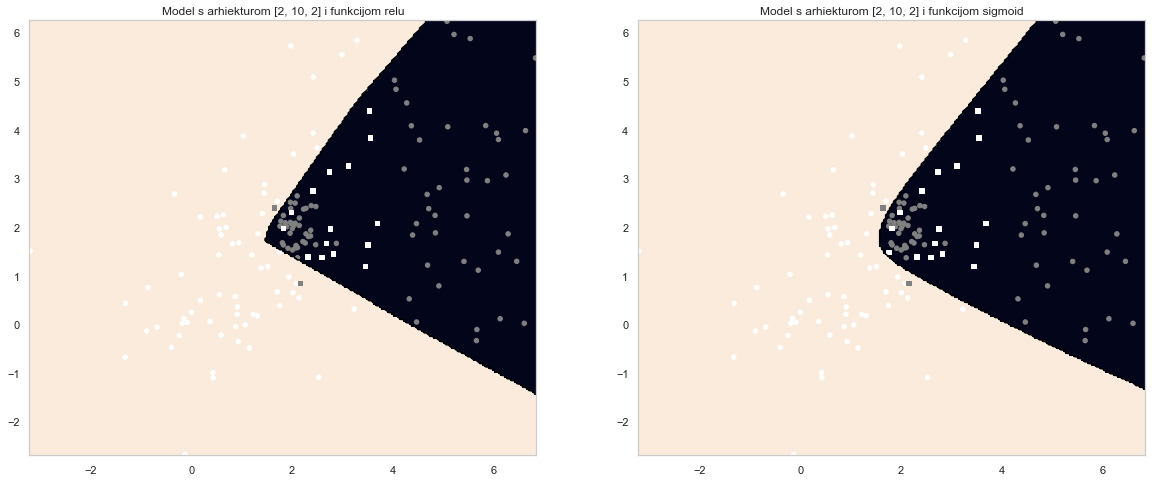

In [17]:
show_relu_sigmoid(x, Y_, arh, akt1, akt2, ptdeep1, Y1, ptdeep2, Y2)

In [18]:
# definiraj model:
arh = [2, 10, 10, 2]

ptdeep1, Y1, ptdeep2, Y2 = train_deep_relu_sigmoid_models(X, Y_, Yoh_, arh, param_niters=6000, 
                                                        param_delta=0.1, param_lambda=1e-4, print_step=1000)

Epoch 0/6000, loss = 1.380047082901001
Epoch 1000/6000, loss = 0.28115683794021606
Epoch 2000/6000, loss = 0.2740758955478668
Epoch 3000/6000, loss = 0.27234378457069397
Epoch 4000/6000, loss = 0.26121169328689575
Epoch 5000/6000, loss = 0.24115708470344543
Accuracy: 0.90625, precision: [(0.975, 0.8571428571428571), (0.8375, 0.9710144927536232)], average precision: 0

Epoch 0/6000, loss = 0.8006778955459595
Epoch 1000/6000, loss = 0.38846996426582336
Epoch 2000/6000, loss = 0.3508324921131134
Epoch 3000/6000, loss = 0.33123236894607544
Epoch 4000/6000, loss = 0.3194769620895386
Epoch 5000/6000, loss = 0.31204500794410706
Accuracy: 0.8875, precision: [(0.975, 0.8297872340425532), (0.8, 0.9696969696969697)], average precision: 0


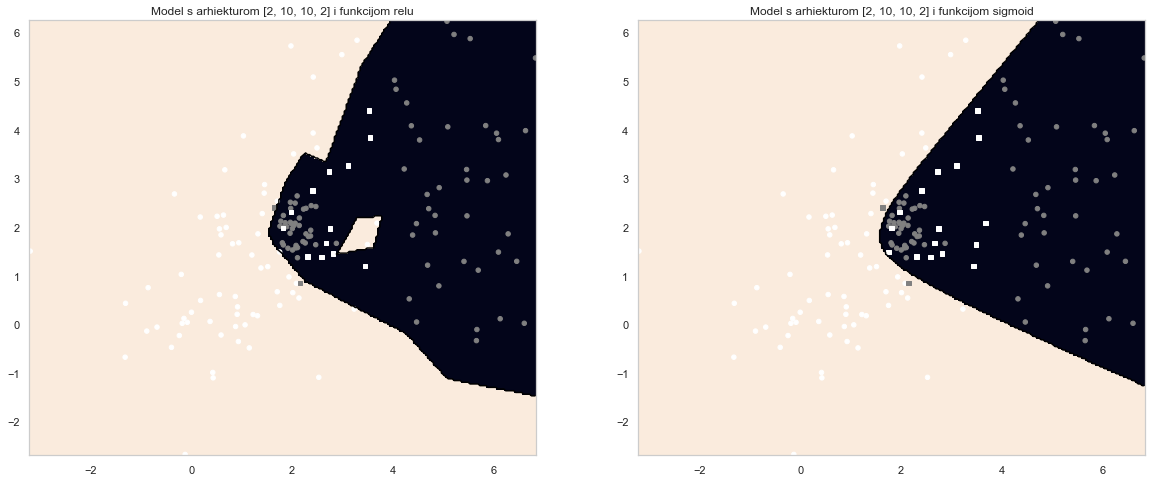

In [19]:
show_relu_sigmoid(x, Y_, arh, akt1, akt2, ptdeep1, Y1, ptdeep2, Y2)

In [20]:
# inicijaliziraj generatore slučajnih brojeva
np.random.seed(100)

# instanciraj podatke X i labele Yoh_
x, Y_ = data.sample_gmm_2d(6, 2, 10)
Yoh = data.class_to_onehot(Y_)
X = torch.Tensor(x)
Yoh_ = torch.Tensor(Yoh)

# definiraj model:
arh = [2, 2]

ptdeep1, Y1, ptdeep2, Y2 = train_deep_relu_sigmoid_models(X, Y_, Yoh_, arh, param_niters=6000, 
                                                        param_delta=0.1, param_lambda=1e-4, print_step=1000)

Epoch 0/6000, loss = 1.0372766256332397
Epoch 1000/6000, loss = 0.6682410836219788
Epoch 2000/6000, loss = 0.6682400703430176
Epoch 3000/6000, loss = 0.6682391166687012
Epoch 4000/6000, loss = 0.6682381629943848
Epoch 5000/6000, loss = 0.6682372093200684
Accuracy: 0.6, precision: [(0.5666666666666667, 0.6071428571428571), (0.6333333333333333, 0.59375)], average precision: 0

Epoch 0/6000, loss = 1.9335353374481201
Epoch 1000/6000, loss = 0.6681991219520569
Epoch 2000/6000, loss = 0.66819828748703
Epoch 3000/6000, loss = 0.6681974530220032
Epoch 4000/6000, loss = 0.6681966781616211
Epoch 5000/6000, loss = 0.6681959629058838
Accuracy: 0.6, precision: [(0.5666666666666667, 0.6071428571428571), (0.6333333333333333, 0.59375)], average precision: 0


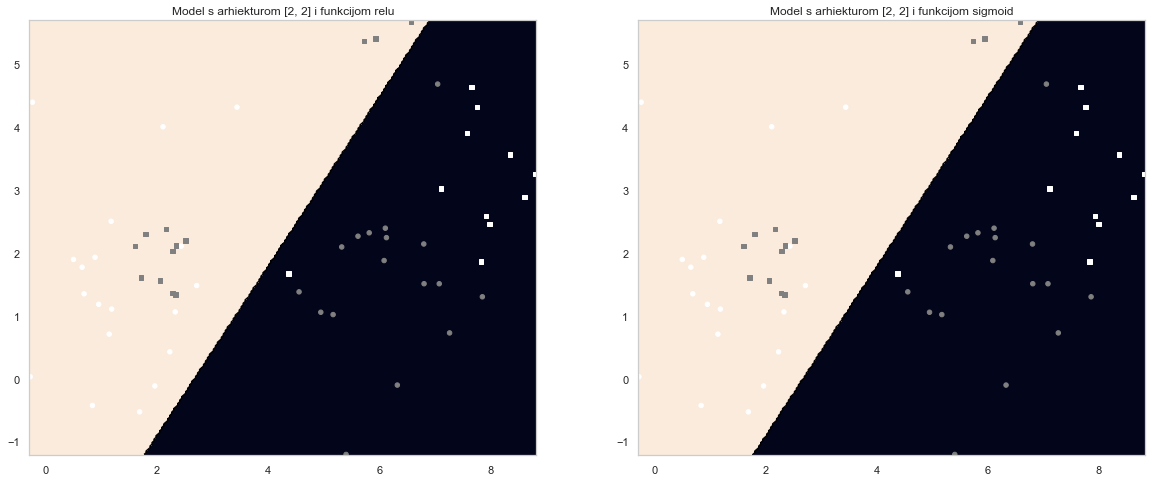

In [21]:
show_relu_sigmoid(x, Y_, arh, akt1, akt2, ptdeep1, Y1, ptdeep2, Y2)

In [22]:
# definiraj model:
arh = [2, 10, 2]

ptdeep1, Y1, ptdeep2, Y2 = train_deep_relu_sigmoid_models(X, Y_, Yoh_, arh, param_niters=6000, 
                                                        param_delta=0.1, param_lambda=1e-4, print_step=1000)

Epoch 0/6000, loss = 1.893320083618164
Epoch 1000/6000, loss = 0.3976624608039856
Epoch 2000/6000, loss = 0.288962721824646
Epoch 3000/6000, loss = 0.2742403447628021
Epoch 4000/6000, loss = 0.18057852983474731
Epoch 5000/6000, loss = 0.2533506155014038
Accuracy: 0.95, precision: [(1.0, 0.9090909090909091), (0.9, 1.0)], average precision: 0

Epoch 0/6000, loss = 0.7184634804725647
Epoch 1000/6000, loss = 0.5313541889190674
Epoch 2000/6000, loss = 0.4292032718658447
Epoch 3000/6000, loss = 0.3640950620174408
Epoch 4000/6000, loss = 0.329482764005661
Epoch 5000/6000, loss = 0.30682891607284546
Accuracy: 0.9333333333333333, precision: [(1.0, 0.8823529411764706), (0.8666666666666667, 1.0)], average precision: 0


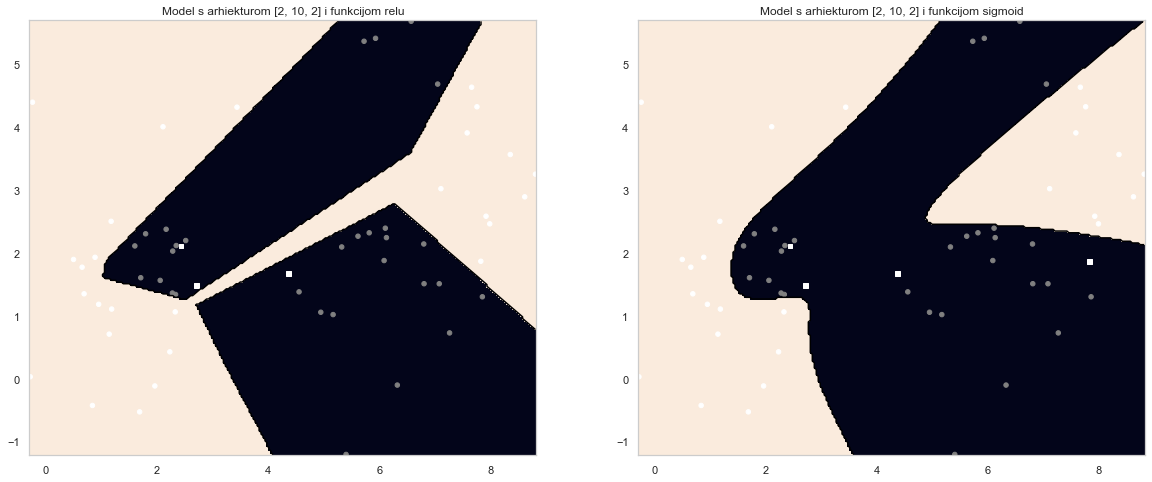

In [23]:
show_relu_sigmoid(x, Y_, arh, akt1, akt2, ptdeep1, Y1, ptdeep2, Y2)

In [24]:
# definiraj model:
arh = [2, 10, 10, 2]

ptdeep1, Y1, ptdeep2, Y2 = train_deep_relu_sigmoid_models(X, Y_, Yoh_, arh, param_niters=6000, 
                                                        param_delta=0.1, param_lambda=1e-4, print_step=1000)

Epoch 0/6000, loss = 0.68547523021698
Epoch 1000/6000, loss = 0.4033191204071045
Epoch 2000/6000, loss = 0.2817106246948242
Epoch 3000/6000, loss = 0.1975477933883667
Epoch 4000/6000, loss = 0.8948898315429688
Epoch 5000/6000, loss = 0.14384056627750397
Accuracy: 0.85, precision: [(0.7333333333333333, 0.9565217391304348), (0.9666666666666667, 0.7837837837837838)], average precision: 0

Epoch 0/6000, loss = 0.7172657251358032
Epoch 1000/6000, loss = 0.5925742387771606
Epoch 2000/6000, loss = 0.5384307503700256
Epoch 3000/6000, loss = 0.47903206944465637
Epoch 4000/6000, loss = 0.41243281960487366
Epoch 5000/6000, loss = 0.3425740897655487
Accuracy: 0.8833333333333333, precision: [(1.0, 0.8108108108108109), (0.7666666666666667, 1.0)], average precision: 0


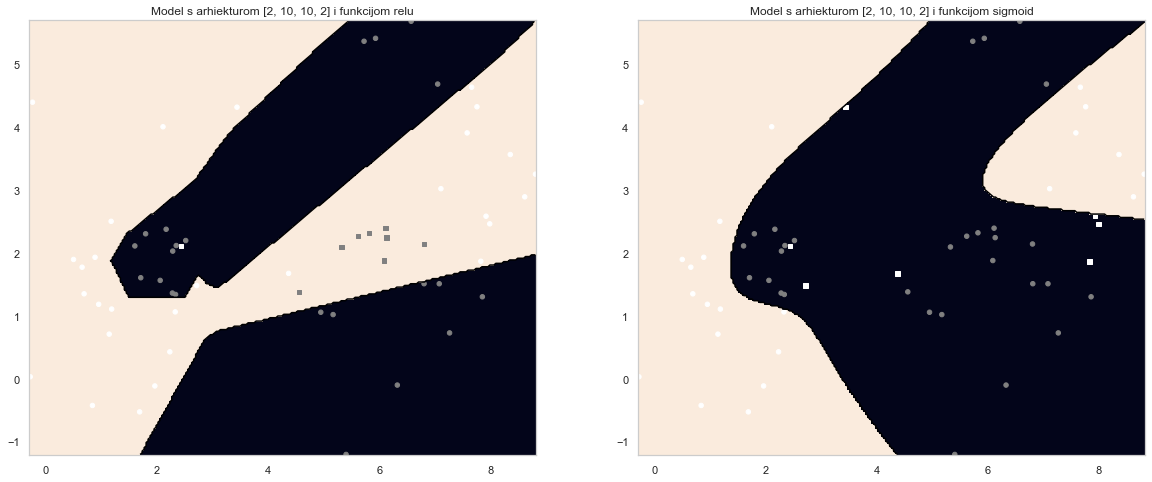

In [25]:
show_relu_sigmoid(x, Y_, arh, akt1, akt2, ptdeep1, Y1, ptdeep2, Y2)

Vidimo kako sigmoida dodatno zaglađuje decizijsku granicu i mirnija je.

## 6. Usporedba s jezgrenim SVM-om (10% bodova)
---
U ovom zadatku uspoređuju se performanse prethodno implementiranog dubokog modela i SVM-a iz biblioteke scikit-learn. 

Accuracy: 0.9333333333333333, precision: [(1.0, 0.8823529411764706), (0.8666666666666667, 1.0)], average precision: 0

Accuracy: 0.65, precision: [(0.6666666666666666, 0.6451612903225806), (0.6333333333333333, 0.6551724137931034)], average precision: 0



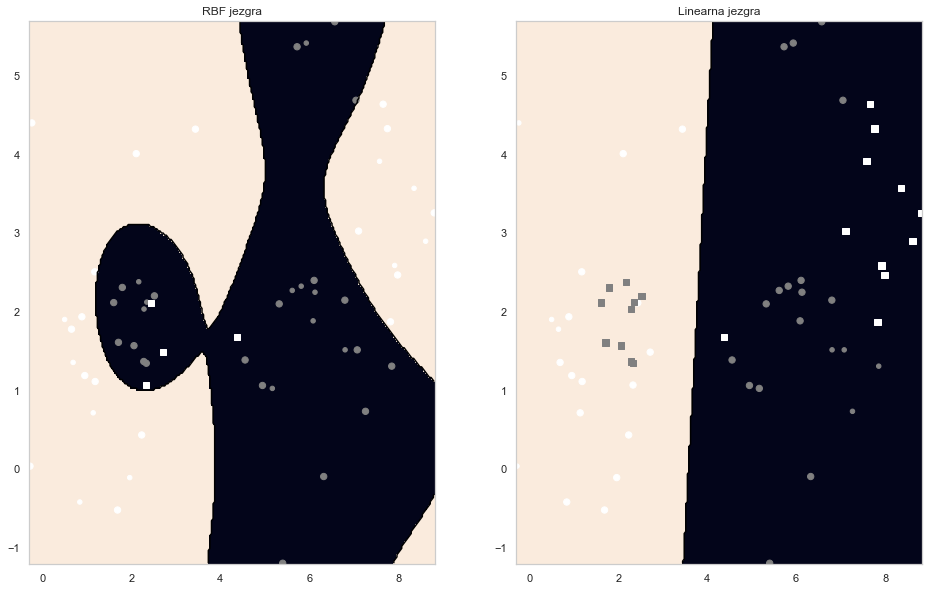

In [26]:
# inicijaliziraj generatore slučajnih brojeva
np.random.seed(100)

# instanciraj podatke X i labele Yoh_
X, Y_ = data.sample_gmm_2d(6, 2, 10)

# definiraj model:
model1 = ksvm_wrap.KSVMWrap(X, Y_, 1, "auto", "rbf")
model2 = ksvm_wrap.KSVMWrap(X, Y_, 1, "auto", "linear")


predictions1 = model1.predict(X)
predictions2 = model2.predict(X)
support_v1 = model1.support()
support_v2 = model2.support()

# ispiši performansu (preciznost i odziv po razredima)
accuracy, precision, M = data.eval_perf_multi(predictions1, Y_)
#avg_precision = data.eval_AP(Y_[probs.argsort()])
avg_precision = 0
print("Accuracy: {}, precision: {}, average precision: {}\n".format(accuracy, precision,
                                                                  avg_precision))
# ispiši performansu (preciznost i odziv po razredima)
accuracy, precision, M = data.eval_perf_multi(predictions2, Y_)
#avg_precision = data.eval_AP(Y_[probs.argsort()])
avg_precision = 0
print("Accuracy: {}, precision: {}, average precision: {}\n".format(accuracy, precision,
                                                                  avg_precision))

# iscrtaj rezultate, decizijsku plohu
figure = plt.figure(figsize=(16, 10))

plt.subplot(1, 2, 1)
bbox = (np.min(X, axis=0), np.max(X, axis=0))
data.graph_surface(model1.predict, bbox, offset=0.5)
data.graph_data(X, Y_, predictions1, special=support_v1)
plt.title("RBF jezgra")

plt.subplot(1, 2, 2)
bbox = (np.min(X, axis=0), np.max(X, axis=0))
data.graph_surface(model2.predict, bbox, offset=0.5)
data.graph_data(X, Y_, predictions2, special=support_v2)
plt.title("Linearna jezgra")

plt.show()

In [27]:
x, Y_ = data.sample_gmm_2d(50, 2, 100)
Yoh = data.class_to_onehot(Y_)
X = torch.Tensor(x).to(device)
Yoh_ = torch.Tensor(Yoh).to(device)

model1 = pt_deep.PTDeep([2, 128, 256, 64,2], torch.relu)
model2 = ksvm_wrap.KSVMWrap(x, Y_, 1, "auto", "linear")

model1.to(device)

pt_deep.train(model1, X, Yoh_, 8000, 0.5, 1e-3, 500)

Y1 = np.argmax(pt_deep.eval(model1, x), axis=1)
Y2 = model2.predict(x)

# ispiši performansu (preciznost i odziv po razredima)
accuracy, precision, M = data.eval_perf_multi(Y1, Y_)
#avg_precision = data.eval_AP(Y_[probs.argsort()])
avg_precision = 0
print("Accuracy: {}, precision: {}, average precision: {}".format(accuracy, precision,
                                                                  avg_precision))

# ispiši performansu (preciznost i odziv po razredima)
accuracy, precision, M = data.eval_perf_multi(Y2, Y_)
#avg_precision = data.eval_AP(Y_[probs.argsort()])
avg_precision = 0
print("Accuracy: {}, precision: {}, average precision: {}".format(accuracy, precision,
                                                                  avg_precision))

Epoch 0/8000, loss = 0.8309372067451477
Epoch 500/8000, loss = 0.6422820687294006
Epoch 1000/8000, loss = 0.6250799894332886
Epoch 1500/8000, loss = 0.6181920170783997
Epoch 2000/8000, loss = 0.5823836922645569
Epoch 2500/8000, loss = 0.6072971820831299
Epoch 3000/8000, loss = 0.5880633592605591
Epoch 3500/8000, loss = 0.5778428316116333
Epoch 4000/8000, loss = 0.5852785110473633
Epoch 4500/8000, loss = 0.5888809561729431
Epoch 5000/8000, loss = 0.5653199553489685
Epoch 5500/8000, loss = 0.5623300671577454
Epoch 6000/8000, loss = 0.5494118928909302
Epoch 6500/8000, loss = 0.5499117970466614
Epoch 7000/8000, loss = 0.5352571606636047
Epoch 7500/8000, loss = 0.5427732467651367
Accuracy: 0.7226, precision: [(0.765, 0.6904851447912749), (0.6834615384615385, 0.7590773173857326)], average precision: 0
Accuracy: 0.6026, precision: [(0.5120833333333333, 0.6009779951100245), (0.6861538461538461, 0.6037225042301184)], average precision: 0


## 7. Studija slučaja: MNIST (20% bodova)
---
MNIST je skup podataka koji se sastoji od rukom pisanih znamenki. Ispitano je ponašanje različitih arhitektura mreže te utjecaj hiperparametara.

In [28]:
x_train, y_train, x_test, y_test = mnist_shootout.load_mnist()

y_oh_train = torch.Tensor(data.class_to_onehot(y_train.detach().numpy()))
y_oh_test = torch.Tensor(data.class_to_onehot(y_test.detach().numpy()))

validation_indices = np.random.choice(range(len(x_train)), int(0.2*len(x_train)), replace=False)
train_indices = list(set(range(len(x_train))) - set(validation_indices))

x_train_smaller = x_train[train_indices, :, :]
y_train_smaller = y_train[train_indices]
x_valid = x_train[validation_indices, :, :]
y_valid = y_train[validation_indices]

y_oh_valid = torch.Tensor(data.class_to_onehot(y_valid.detach().numpy()))
y_oh_train_smaller = torch.Tensor(data.class_to_onehot(y_train_smaller.detach().numpy()))

Regularizacijski koeficijent je  0


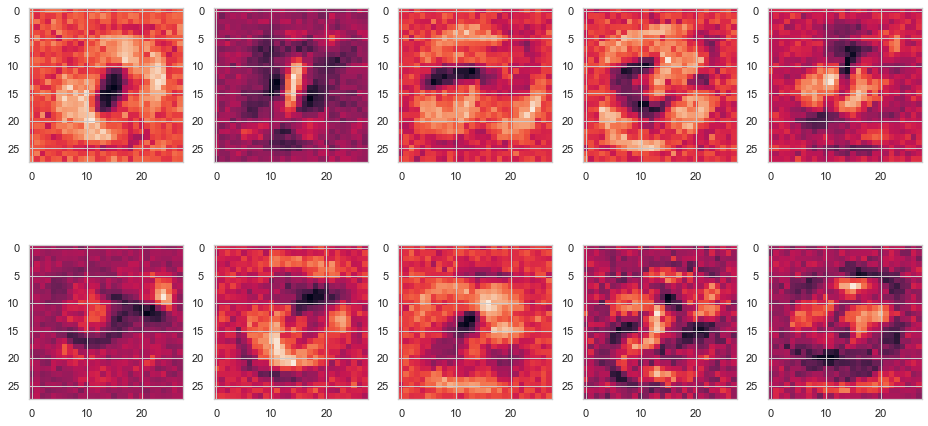

Regularizacijski koeficijent je  0.001


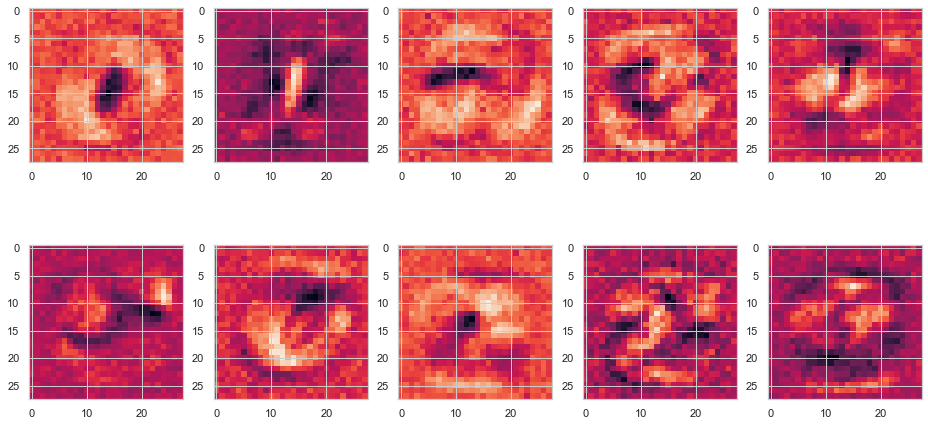

Regularizacijski koeficijent je  0.1


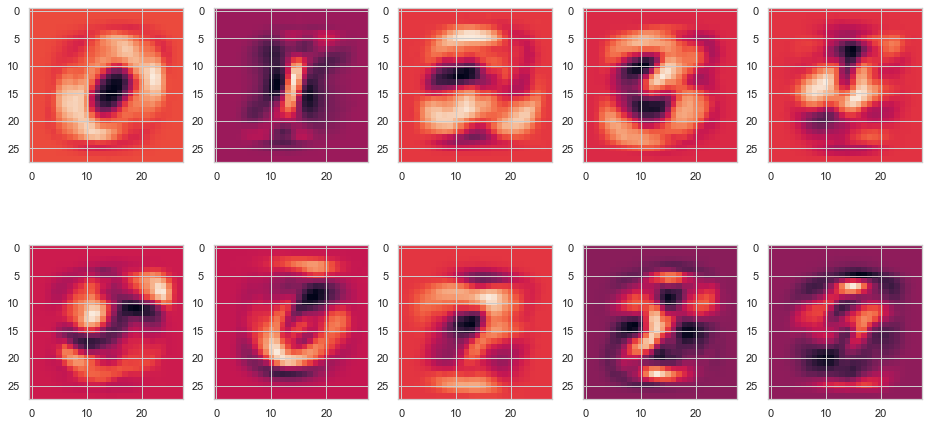

Regularizacijski koeficijent je  0.9


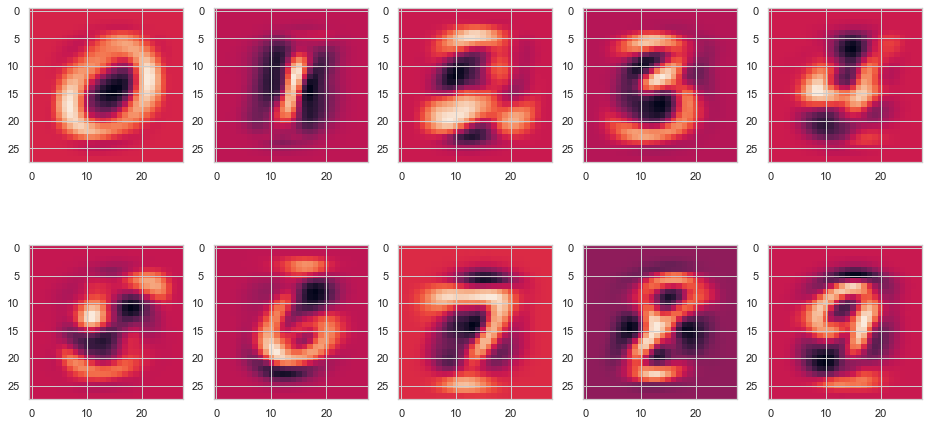

In [29]:
mnist_shootout.train_weights_regularization(x_train, y_oh_train)

Rezultati:
    - s povećanjem lambde dobivamo zaglađenije maske težine

In [30]:
mnist_shootout.evaluate_init_model(x_train, y_train, y_oh_train, x_test, y_test, y_oh_test)

Train | Loss: 2.368697166442871, accuracy: 9.46%
Test  | Loss: 2.3654074668884277, accuracy: 9.83%


C:\Users\Jelena\PycharmProjects\DL_FER\Lab1\data.py:137: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_i = tp_i / (tp_i + fp_i)


Rezultati:

Train | Loss: 2.3297040462493896, accuracy: 11.42%, 
Test  | Loss: 2.3272650241851807, accuracy: 11.68%

Odgovara nasumičnom biranju jedne od 10 klasa.


Starting with architecture:  [784, 10]
Epoch 0/3000, loss = 2.4807355403900146
Epoch 1000/3000, loss = 0.34925058484077454
Epoch 2000/3000, loss = 0.3160543441772461

Train| Accuracy: 0.9164, precision_recall: [(0.9655579942596657, 0.9520559347428), (0.9694452684663305, 0.941922467214296), (0.8858677408526351, 0.913622987709884), (0.8887620290327842, 0.9039482415394824), (0.9282779869907566, 0.9143483392345304), (0.862202545655783, 0.8887621220764403), (0.9537005745184184, 0.9356763925729443), (0.9254588986432561, 0.9314056224899598), (0.880020509314647, 0.8847079037800687), (0.8932593713229114, 0.8883316616516216)]

Test| Accuracy: 0.9188, precision_recall: [(0.9795918367346939, 0.9495548961424333), (0.973568281938326, 0.963382737576286), (0.8798449612403101, 0.9322381930184805), (0.9089108910891089, 0.898238747553816), (0.9338085539714868, 0.908820614469772), (0.8565022421524664, 0.9073634204275535), (0.9530271398747391, 0.9287894201424212), (0.9163424124513618, 0.9235294117647059), 

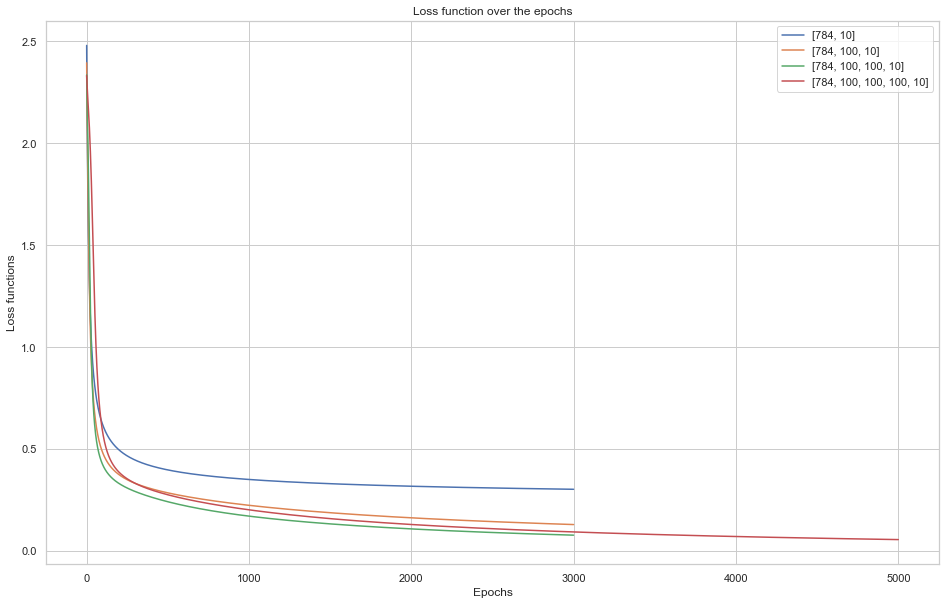

In [31]:
architectures, losses, train_stats, test_stats = mnist_shootout.train_multiple_architectures(x_train, 
                                                                                             y_train, 
                                                                                             y_oh_train, 
                                                                                             x_test, 
                                                                                             y_test)
mnist_shootout.show_loss(losses, architectures)

Starting with architecture:  [784, 10]
Epoch 0/3000, loss = 2.4807355403900146
Epoch 1000/3000, loss = 0.34925058484077454
Epoch 2000/3000, loss = 0.3160543441772461

Train| Accuracy: 0.9164, precision_recall: [(0.9655579942596657, 0.9520559347428), (0.9694452684663305, 0.941922467214296), (0.8858677408526351, 0.913622987709884), (0.8887620290327842, 0.9039482415394824), (0.9282779869907566, 0.9143483392345304), (0.862202545655783, 0.8887621220764403), (0.9537005745184184, 0.9356763925729443), (0.9254588986432561, 0.9314056224899598), (0.880020509314647, 0.8847079037800687), (0.8932593713229114, 0.8883316616516216)]

Test| Accuracy: 0.9188, precision_recall: [(0.9795918367346939, 0.9495548961424333), (0.973568281938326, 0.963382737576286), (0.8798449612403101, 0.9322381930184805), (0.9089108910891089, 0.898238747553816), (0.9338085539714868, 0.908820614469772), (0.8565022421524664, 0.9073634204275535), (0.9530271398747391, 0.9287894201424212), (0.9163424124513618, 0.9235294117647059), (0.8850102669404517, 0.8689516129032258), (0.8909811694747275, 0.899)]

Starting with architecture:  [784, 100, 10]
Epoch 0/3000, loss = 2.3951518535614014
Epoch 1000/3000, loss = 0.2223583608865738
Epoch 2000/3000, loss = 0.16091148555278778

Train| Accuracy: 0.9654666666666667, precision_recall: [(0.9810906635151105, 0.9776244952893675), (0.9830910708988431, 0.9737035404730424), (0.9644175897952333, 0.9655520080658713), (0.9536780296852063, 0.9629446640316206), (0.9623416638137624, 0.9602049530315969), (0.9566500645637336, 0.9610822831727205), (0.9775261912808382, 0.972595830531271), (0.9667996807661612, 0.9674173454719693), (0.955221329687233, 0.9606393949810932), (0.9509161203563624, 0.9510759919300605)]

Test| Accuracy: 0.9594, precision_recall: [(0.9846938775510204, 0.9611553784860558), (0.9841409691629956, 0.97384481255449), (0.9622093023255814, 0.9650145772594753), (0.9663366336633663, 0.9439071566731141), (0.9572301425661914, 0.9572301425661914), (0.9473094170403588, 0.9624145785876993), (0.9624217118997912, 0.9604166666666667), (0.9474708171206225, 0.9586614173228346), (0.9455852156057495, 0.9544041450777202), (0.9326065411298315, 0.9553299492385787)]

Starting with architecture:  [784, 100, 100, 10]
Epoch 0/3000, loss = 2.3357346057891846
Epoch 1000/3000, loss = 0.16922210156917572
Epoch 2000/3000, loss = 0.10651223361492157

Train| Accuracy: 0.9804666666666667, precision_recall: [(0.9871686645281108, 0.9848408287013644), (0.9888757045387125, 0.9852224028372987), (0.9791876468613628, 0.9782025486250838), (0.9725982710813896, 0.9818870410011526), (0.9818555289284492, 0.9785056294779939), (0.9782327983766833, 0.9787744555186416), (0.9885096316323082, 0.985512129380054), (0.9813248204309657, 0.9796048438495857), (0.9738506238249872, 0.9751839808317645), (0.9719280551353169, 0.9760297096556381)]

Test| Accuracy: 0.9698, precision_recall: [(0.9836734693877551, 0.9757085020242915), (0.9876651982378855, 0.9824715162138475), (0.9738372093023255, 0.9747817652764307), (0.9712871287128713, 0.9684106614017769), (0.9714867617107943, 0.9665653495440729), (0.9607623318385651, 0.9650900900900901), (0.9707724425887265, 0.9627329192546584), (0.9630350194552529, 0.9639727361246349), (0.9599589322381931, 0.9709241952232607), (0.9524281466798811, 0.964859437751004)]

Starting with architecture:  [784, 100, 100, 100, 10]
Epoch 0/5000, loss = 2.3322770595550537
Epoch 1000/5000, loss = 0.20024289190769196
Epoch 2000/5000, loss = 0.12817421555519104
Epoch 3000/5000, loss = 0.0915689542889595
Epoch 4000/5000, loss = 0.0690803974866867

Train| Accuracy: 0.9871166666666666, precision_recall: [(0.9912206652034442, 0.9907188660141748), (0.9927321269652922, 0.9892107596807568), (0.9874118831822759, 0.9849321948769463), (0.9812428641330941, 0.9896364533640402), (0.9876754536117768, 0.9841378134061061), (0.9867183176535694, 0.9890902366863905), (0.9917201757350457, 0.9897133220910624), (0.9851556264964086, 0.9859424920127795), (0.9854725687916596, 0.9844630356837971), (0.9813414019162885, 0.9831593128999663)]

Test| Accuracy: 0.9741, precision_recall: [(0.9887755102040816, 0.9728915662650602), (0.9903083700440528, 0.9859649122807017), (0.9709302325581395, 0.9766081871345029), (0.9811881188118812, 0.970617042115573), (0.9684317718940937, 0.9743852459016393), (0.9641255605381166, 0.9717514124293786), (0.9718162839248434, 0.9758909853249476), (0.9795719844357976, 0.9757751937984496), (0.9579055441478439, 0.9638429752066116), (0.9643211100099108, 0.9710578842315369)]

Model with architecture [784, 100, 10] and lambda 0
Epoch 0/3001, loss = 2.441305160522461
Epoch 1000/3001, loss = 0.22589944303035736
Epoch 2000/3001, loss = 0.16208288073539734
Epoch 3000/3001, loss = 0.1260586827993393

Train| Accuracy: 0.9650833333333333, precision_recall: [(0.9814283302380551, 0.9768106200638548), (0.9826460990803916, 0.9738350727620168), (0.9573682443773078, 0.9635135135135136), (0.9492741803947153, 0.9619834710743802), (0.9642245806230743, 0.9627414117244916), (0.9579413392363033, 0.9627363737486095), (0.978202095302467, 0.9693569993302076), (0.9711093375897846, 0.9706445437141034), (0.9529994872671338, 0.9554489376285127), (0.9527651706169104, 0.9518052057094878)]

Test| Accuracy: 0.9595, precision_recall: [(0.9846938775510204, 0.9630738522954092), (0.9841409691629956, 0.978965819456617), (0.9554263565891473, 0.9638318670576735), (0.9633663366336633, 0.9511241446725318), (0.955193482688391, 0.955193482688391), (0.9461883408071748, 0.9623717217787914), (0.961377

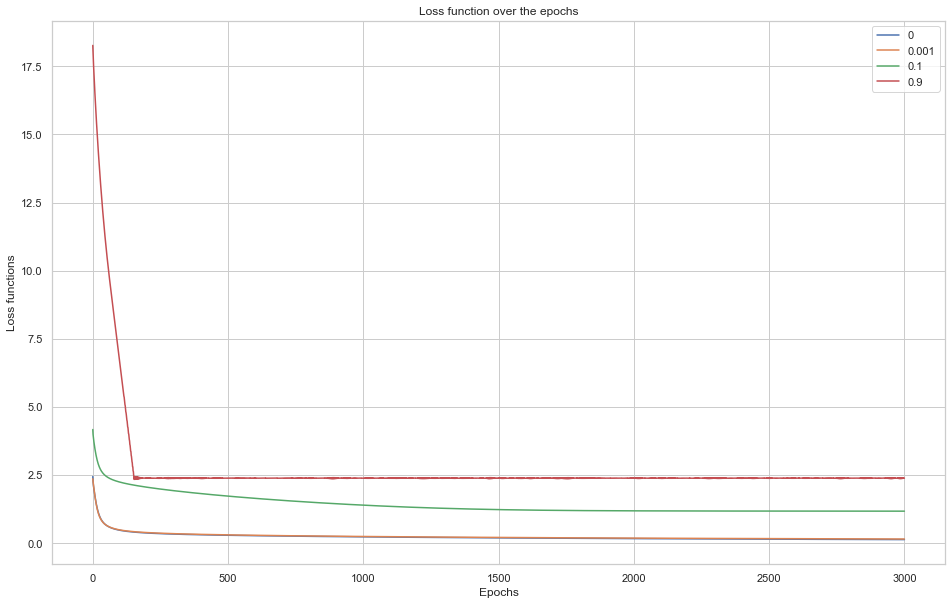

In [32]:
losses, lambdas = mnist_shootout.train_test_regularization(x_train, y_train, y_oh_train, x_test, y_test)
mnist_shootout.show_loss(losses, lambdas)

Model with architecture [784, 100, 10] and lambda 0
Epoch 0/3001, loss = 2.441305160522461
Epoch 1000/3001, loss = 0.22589944303035736
Epoch 2000/3001, loss = 0.16208288073539734
Epoch 3000/3001, loss = 0.1260586827993393

Train| Accuracy: 0.9650833333333333, precision_recall: [(0.9814283302380551, 0.9768106200638548), (0.9826460990803916, 0.9738350727620168), (0.9573682443773078, 0.9635135135135136), (0.9492741803947153, 0.9619834710743802), (0.9642245806230743, 0.9627414117244916), (0.9579413392363033, 0.9627363737486095), (0.978202095302467, 0.9693569993302076), (0.9711093375897846, 0.9706445437141034), (0.9529994872671338, 0.9554489376285127), (0.9527651706169104, 0.9518052057094878)]

Test| Accuracy: 0.9595, precision_recall: [(0.9846938775510204, 0.9630738522954092), (0.9841409691629956, 0.978965819456617), (0.9554263565891473, 0.9638318670576735), (0.9633663366336633, 0.9511241446725318), (0.955193482688391, 0.955193482688391), (0.9461883408071748, 0.9623717217787914), (0.9613778705636743, 0.9544041450777202), (0.9542801556420234, 0.960822722820764), (0.9435318275154004, 0.9513457556935818), (0.9425173439048563, 0.951)]

Model with architecture [784, 100, 10] and lambda 0.001
Epoch 0/3001, loss = 2.3597726821899414
Epoch 1000/3001, loss = 0.24016807973384857
Epoch 2000/3001, loss = 0.17994561791419983
Epoch 3000/3001, loss = 0.14743565022945404

Train| Accuracy: 0.9653166666666667, precision_recall: [(0.9810906635151105, 0.97778899545684), (0.9844259863541975, 0.9745961820851688), (0.9603893924135616, 0.9657383966244726), (0.9496003914532702, 0.9608846344281234), (0.9659363231769942, 0.9624765478424016), (0.957387935805202, 0.9600443951165372), (0.9776951672862454, 0.9703169545530773), (0.9703112529928173, 0.9692283163265306), (0.9519740215347804, 0.9573736679271228), (0.9512523113128257, 0.95253324356169)]

Test| Accuracy: 0.9615, precision_recall: [(0.986734693877551, 0.967), (0.9841409691629956, 0.978108581436077), (0.9612403100775194, 0.9640427599611273), (0.9603960396039604, 0.9481915933528837), (0.960285132382892, 0.9651995905834186), (0.945067264573991, 0.9623287671232876), (0.965553235908142, 0.9555785123966942), (0.9562256809338522, 0.961839530332681), (0.9496919917864476, 0.952626158599382), (0.9415262636273538, 0.9576612903225806)]

Model with architecture [784, 100, 10] and lambda 0.1
Epoch 0/3001, loss = 4.1672468185424805
Epoch 1000/3001, loss = 1.3900485038757324
Epoch 2000/3001, loss = 1.1813702583312988
Epoch 3000/3001, loss = 1.16971755027771

Train| Accuracy: 0.9067833333333334, precision_recall: [(0.9611683268613878, 0.945210028225137), (0.9727083951349748, 0.904177581690335), (0.865055387713998, 0.9152903569525839), (0.8687000489316588, 0.9011844331641286), (0.9180075316672373, 0.8957741773843327), (0.8653384984320236, 0.8889520560924767), (0.9459276782696857, 0.9181564703952764), (0.9209896249002394, 0.9224620303756994), (0.8560929755597334, 0.8946240400071441), (0.8816607833249286, 0.8788538873994638)]

Test| Accuracy: 0.9107, precision_recall: [(0.976530612244898, 0.9336585365853659), (0.9770925110132158, 0.9319327731092437), (0.8653100775193798, 0.918724279835391), (0.9, 0.9), (0.9266802443991853, 0.8860759493670886), (0.8542600896860987, 0.8996458087367178), (0.9373695198329853, 0.9200819672131147), (0.9036964980544747, 0.9243781094527364), (0.8624229979466119, 0.89171974522293), (0.8919722497522299, 0.8946322067594433)]

Model with architecture [784, 100, 10] and lambda 0.9
Epoch 0/3001, loss = 18.26896095275879
Epoch 1000/3001, loss = 2.3793892860412598
Epoch 2000/3001, loss = 2.3892743587493896
Epoch 3000/3001, loss = 2.382612943649292

Train| Accuracy: 0.11236666666666667, precision_recall: [(0.0, nan), (1.0, 0.11236666666666667), (0.0, nan), (0.0, nan), (0.0, nan), (0.0, nan), (0.0, nan), (0.0, nan), (0.0, nan), (0.0, nan)]

Test| Accuracy: 0.1135, precision_recall: [(0.0, nan), (1.0, 0.1135), (0.0, nan), (0.0, nan), (0.0, nan), (0.0, nan), (0.0, nan), (0.0, nan), (0.0, nan), (0.0, nan)]


In [33]:
mnist_shootout.train_test_early_stopping(x_train, y_oh_train, y_train, x_train_smaller, y_oh_train_smaller, x_valid, 
                                         y_valid, x_test, y_oh_test, y_test, 0.1, 10001, 1e-4, 1000)

Epoch 0/30001, loss = 2.4404144287109375
Epoch 1000/30001, loss = 0.2209136039018631
Epoch 2000/30001, loss = 0.15672047436237335
Epoch 3000/30001, loss = 0.1225733831524849
Epoch 4000/30001, loss = 0.10081254690885544
Epoch 5000/30001, loss = 0.08530212193727493
Epoch 6000/30001, loss = 0.07365861535072327
Epoch 7000/30001, loss = 0.06447114795446396


KeyboardInterrupt: 

Rezultati:

Epoch 0/3001, loss = 2.3717432022094727

Epoch 1000/3001, loss = 0.2164486199617386

Epoch 2000/3001, loss = 0.15337111055850983

Epoch 3000/3001, loss = 0.11924105882644653

Best model is from epoch  3000

Train | Loss: 0.12243248522281647, accuracy: 96.61%, 
Test  | Loss: 0.13066352903842926, accuracy: 96.11%


Starting with the batch size of  64
Step 0, loss: 2.4089179039001465
Step 100, loss: 0.5166383385658264
Step 200, loss: 0.2687271237373352
Step 300, loss: 0.2957722246646881
Step 400, loss: 0.2956531047821045
Step 500, loss: 0.36722519993782043
Step 600, loss: 0.22106826305389404
Step 700, loss: 0.27694305777549744
Step 800, loss: 0.1714424341917038
Step 900, loss: 0.2282007783651352
Epoch 0/51, loss = 0.37988319993019104
Step 0, loss: 0.01564568467438221
Step 100, loss: 0.009012567810714245
Step 200, loss: 0.02922404184937477
Step 300, loss: 0.031241144984960556
Step 400, loss: 0.038442280143499374
Step 500, loss: 0.0325186587870121
Step 600, loss: 0.020149076357483864
Step 700, loss: 0.035309821367263794
Step 800, loss: 0.016224494203925133
Step 900, loss: 0.017014075070619583
Epoch 25/51, loss = 0.022223036736249924
Step 0, loss: 0.010276896879076958
Step 100, loss: 0.00686568021774292
Step 200, loss: 0.014242088422179222
Step 300, loss: 0.012026691809296608
Step 400, loss: 0.006404

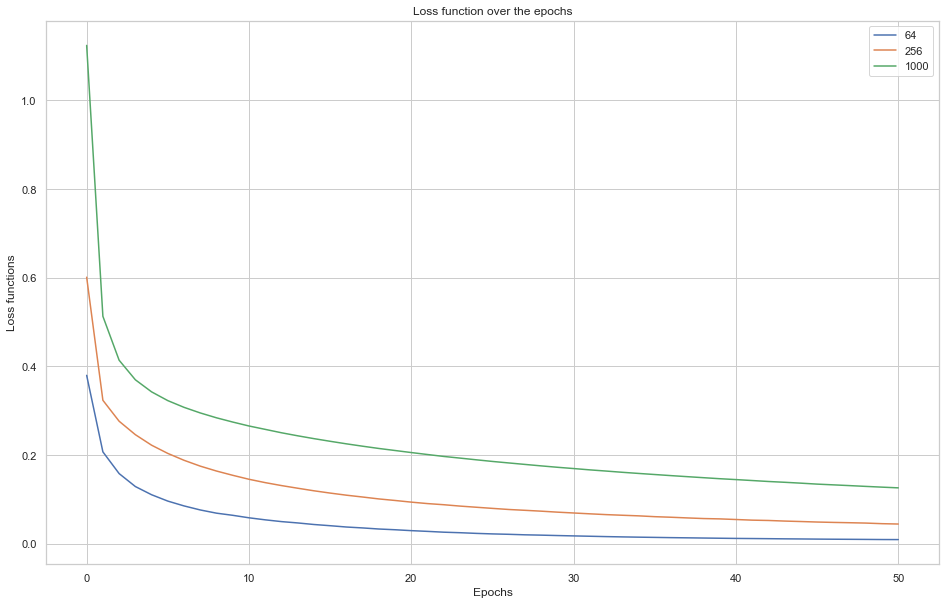

In [35]:
losses, batches = mnist_shootout.train_mb(x_train, y_oh_train, y_train, x_test, y_oh_test, y_test, 0.1, 1e-4, 25, 51)
mnist_shootout.show_loss(losses, batches)

Rezultati:

Mini batch je puno točniji, loss se više smanjuje i postižu se bolje performanse.

Starting with the batch size of  64
Step 0, loss: 2.4089179039001465
Step 100, loss: 0.5166383385658264
Step 200, loss: 0.2687271237373352
Step 300, loss: 0.2957722246646881
Step 400, loss: 0.2956531047821045
Step 500, loss: 0.36722519993782043
Step 600, loss: 0.22106826305389404
Step 700, loss: 0.27694305777549744
Step 800, loss: 0.1714424341917038
Step 900, loss: 0.2282007783651352
Epoch 0/51, loss = 0.37988319993019104
Step 0, loss: 0.01564568467438221
Step 100, loss: 0.009012567810714245
Step 200, loss: 0.02922404184937477
Step 300, loss: 0.031241144984960556
Step 400, loss: 0.038442280143499374
Step 500, loss: 0.0325186587870121
Step 600, loss: 0.020149076357483864
Step 700, loss: 0.035309821367263794
Step 800, loss: 0.016224494203925133
Step 900, loss: 0.017014075070619583
Epoch 25/51, loss = 0.022223036736249924
Step 0, loss: 0.010276896879076958
Step 100, loss: 0.00686568021774292
Step 200, loss: 0.014242088422179222
Step 300, loss: 0.012026691809296608
Step 400, loss: 0.006404552608728409
Step 500, loss: 0.007598293479532003
Step 600, loss: 0.006326427683234215
Step 700, loss: 0.008913540281355381
Step 800, loss: 0.00963765662163496
Step 900, loss: 0.008003155700862408
Epoch 50/51, loss = 0.009406284429132938
Train | Loss: 0.004723113961517811, accuracy: 99.99%
Test  | Loss: 0.07296230643987656, accuracy: 97.98%
Starting with the batch size of  256
Step 0, loss: 2.3100500106811523
Step 100, loss: 0.4238429665565491
Step 200, loss: 0.4413607716560364
Epoch 0/51, loss = 0.6012916564941406
Step 0, loss: 0.11160667985677719
Step 100, loss: 0.09875396639108658
Step 200, loss: 0.09841878712177277
Epoch 25/51, loss = 0.07980478554964066
Step 0, loss: 0.047290779650211334
Step 100, loss: 0.04411571845412254
Step 200, loss: 0.02963956817984581
Epoch 50/51, loss = 0.04450594633817673
Train | Loss: 0.03949491307139397, accuracy: 99.04%
Test  | Loss: 0.07593049108982086, accuracy: 97.60%
Starting with the batch size of  1000
Step 0, loss: 2.365447521209717
Epoch 0/51, loss = 1.124116063117981
Step 0, loss: 0.16791170835494995
Epoch 25/51, loss = 0.18568095564842224
Step 0, loss: 0.13128527998924255
Epoch 50/51, loss = 0.1261025071144104
Train | Loss: 0.1220666840672493, accuracy: 96.61%
Test  | Loss: 0.13188840448856354, accuracy: 96.23%

In [36]:
losses = mnist_shootout.train_adam(x_train, y_oh_train, y_train, x_test, y_test, y_oh_test, 1e-4, 3001, 1e-2, 1000, False)

Epoch 0/3001, loss = 2.559661388397217
Epoch 1000/3001, loss = 0.44188281893730164
Epoch 2000/3001, loss = 0.3536786139011383
Epoch 3000/3001, loss = 0.3073986768722534
Train | Loss: 0.13730409741401672, accuracy: 96.41%
Test  | Loss: 0.14599792659282684, accuracy: 96.01%


Epoch 0/3001, loss = 2.3995392322540283
Epoch 1000/3001, loss = 0.2595844864845276
Epoch 2000/3001, loss = 0.17482136189937592
Epoch 3000/3001, loss = 0.12428560107946396
Train | Loss: 0.12140293419361115, accuracy: 96.67%
Test  | Loss: 0.13839703798294067, accuracy: 95.94%


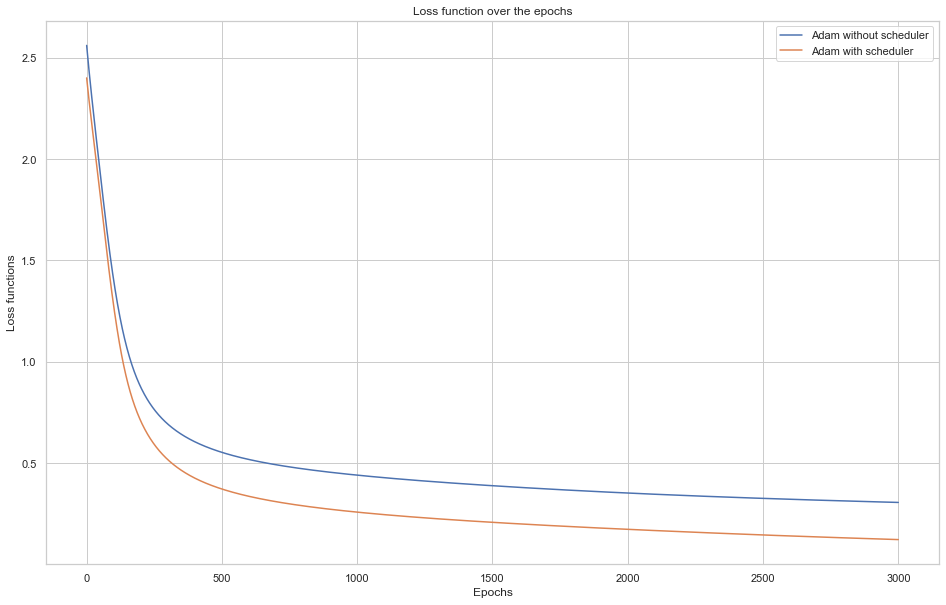

In [37]:
losses2 = mnist_shootout.train_adam(x_train, y_oh_train, y_train, x_test, y_test, y_oh_test, 1e-4, 3001, 1e-4, 1000, 
                                    True, 1-1e-4)
mnist_shootout.show_loss([losses, losses2], ["Adam without scheduler", "Adam with scheduler"])

Rezultati:

Adam više smanjuje loss i daje bolju točnost. Loss je više smanjen kad je korišten scheduler.

Epoch 0/3001, loss = 2.559661388397217

Epoch 1000/3001, loss = 0.44188281893730164

Epoch 2000/3001, loss = 0.3536786139011383

Epoch 3000/3001, loss = 0.3073986768722534

Train | Loss: 0.13730409741401672, accuracy: 96.41%, Test  | Loss: 0.14599792659282684, accuracy: 96.01%

---

Epoch 0/3001, loss = 2.3995392322540283

Epoch 1000/3001, loss = 0.2595844864845276

Epoch 2000/3001, loss = 0.17482136189937592

Epoch 3000/3001, loss = 0.12428560107946396

Train | Loss: 0.12140293419361115, accuracy: 96.67%, Test  | Loss: 0.13839703798294067, accuracy: 95.94%

In [38]:
mnist_shootout.svm2(x_train, y_train, x_test, y_test)

Linear SVM | Accuracy: 0.9404, precision_recall: [(0.976530612244898, 0.9522388059701492), (0.9885462555066079, 0.9697493517718236), (0.937015503875969, 0.9253588516746412), (0.9376237623762376, 0.9062200956937799), (0.9592668024439919, 0.9363817097415507), (0.9002242152466368, 0.9145785876993167), (0.9498956158663883, 0.9568874868559412), (0.9309338521400778, 0.9522388059701492), (0.9004106776180698, 0.936965811965812), (0.9137760158572844, 0.948559670781893)]

RBF SVM | Accuracy: 0.9792, precision_recall: [(0.9928571428571429, 0.9798590130916415), (0.9920704845814978, 0.9885864793678666), (0.9748062015503876, 0.9757516973811833), (0.9851485148514851, 0.9745347698334965), (0.9786150712830958, 0.9826175869120655), (0.976457399103139, 0.986409966024915), (0.9853862212943633, 0.9853862212943633), (0.9688715953307393, 0.9755142017629774), (0.9753593429158111, 0.9713701431492843), (0.9613478691774033, 0.9719438877755511)]


Linear SVM | Accuracy: 0.9404, precision_recall: [(0.976530612244898, 0.9522388059701492), (0.9885462555066079, 0.9697493517718236), (0.937015503875969, 0.9253588516746412), (0.9376237623762376, 0.9062200956937799), (0.9592668024439919, 0.9363817097415507), (0.9002242152466368, 0.9145785876993167), (0.9498956158663883, 0.9568874868559412), (0.9309338521400778, 0.9522388059701492), (0.9004106776180698, 0.936965811965812), (0.9137760158572844, 0.948559670781893)]

RBF SVM | Accuracy: 0.9792, precision_recall: [(0.9928571428571429, 0.9798590130916415), (0.9920704845814978, 0.9885864793678666), (0.9748062015503876, 0.9757516973811833), (0.9851485148514851, 0.9745347698334965), (0.9786150712830958, 0.9826175869120655), (0.976457399103139, 0.986409966024915), (0.9853862212943633, 0.9853862212943633), (0.9688715953307393, 0.9755142017629774), (0.9753593429158111, 0.9713701431492843), (0.9613478691774033, 0.9719438877755511)]